In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import dill
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sbi.inference import FMPE, SNPE, NPSE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
import sbibm
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.test_statistics.waldo import Waldo
from lf2i.calibration.critical_values import train_qr_algorithm
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.plot.coverage_diagnostics import coverage_probability_plot
from lf2i.plot.power_diagnostics import set_size_plot
from tsi.temp.utils import kdeplots2D

2025-10-31 08:00:49.422533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-31 08:00:49.422653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-31 08:00:49.494644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-31 08:00:49.643806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-31 08:00:51.703051: W tensorflow/compiler/tf2

In [3]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

In [4]:
### Settings
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 0.1 # (6*np.sqrt(2.0))**2
POI_BOUNDS = {r'$\theta_1$': (-1, 1), r'$\theta_2$': (-1, 1)}
PRIOR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
)

B = 100_000  # num simulations to estimate posterior and test statistics
B_PRIME = 50_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 30_000  # num simulations to do diagnostics
EVAL_GRID_SIZE = 1_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.954, 0.683  # 0.99

REFERENCE = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
)
EVAL_GRID_DISTR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][0])),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1], POI_BOUNDS[r'$\theta_2$'][1]))
)

POSTERIOR_KWARGS = {
    'norm_posterior': None
}
DEVICE = 'cpu'
task = sbibm.get_task('two_moons')
simulator = task.get_simulator()

# Strong prior

In [74]:
experiment_dir = 'results/fmpe/old_strong_prior'
with open(f'{experiment_dir}/obs_x_theta.pkl', 'rb') as f:
    examples = dill.load(f)
    true_theta = examples['true_theta']
    obs_x = examples['obs_x']

PRIOR_VAR = 0.1 # (6*np.sqrt(2.0))**2
POI_BOUNDS = {r'$\theta_1$': (-1, 1), r'$\theta_2$': (-1, 1)}
PRIOR = MultivariateNormal(
    loc=torch.Tensor([0.5, 0.5]), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)

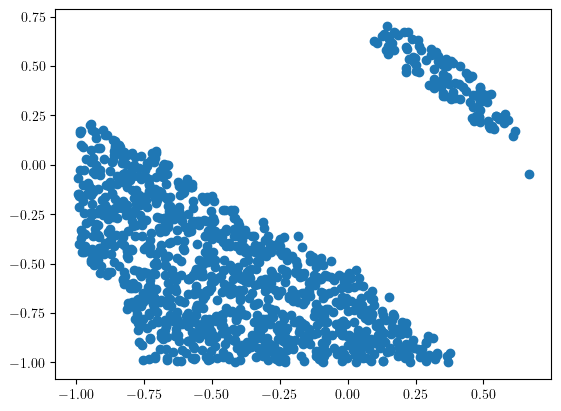

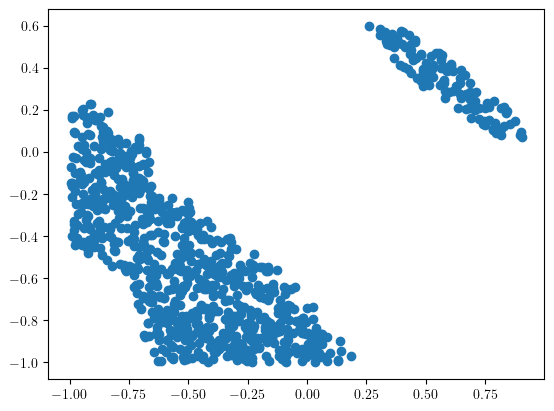

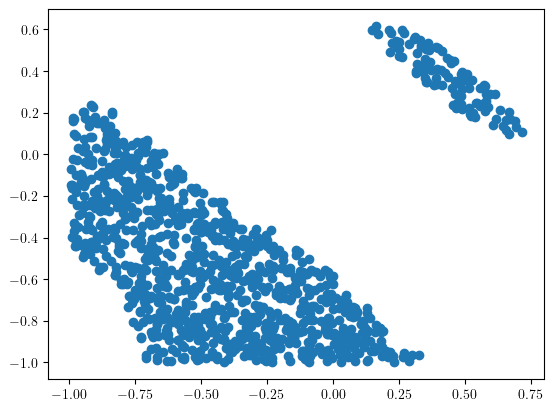

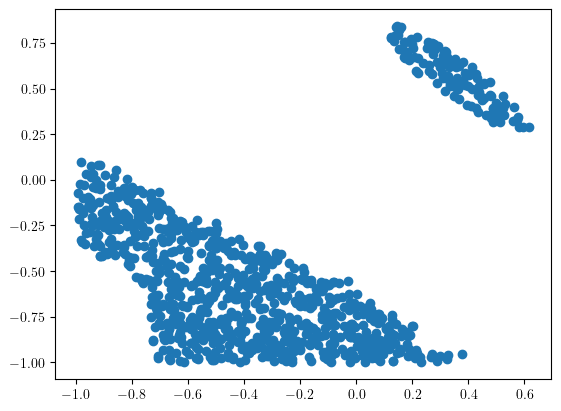

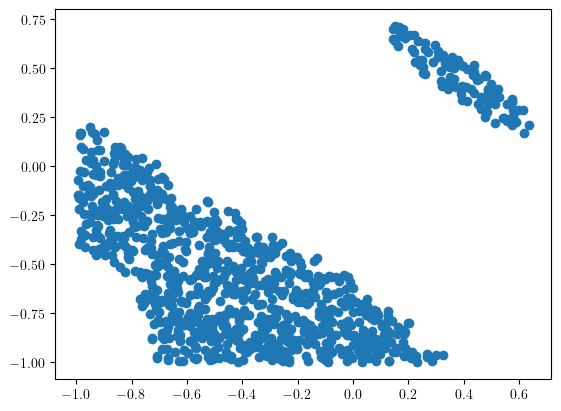

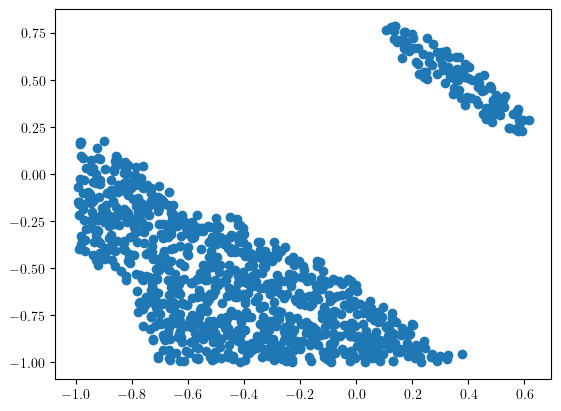

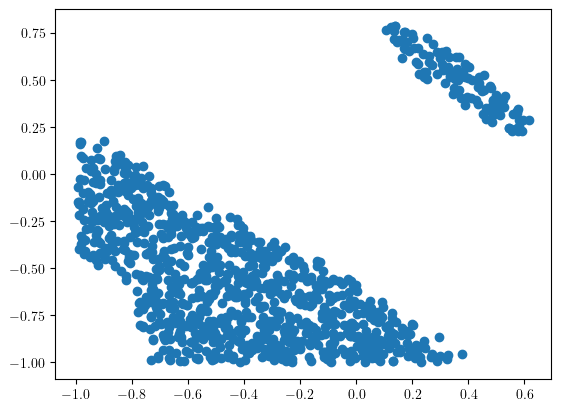

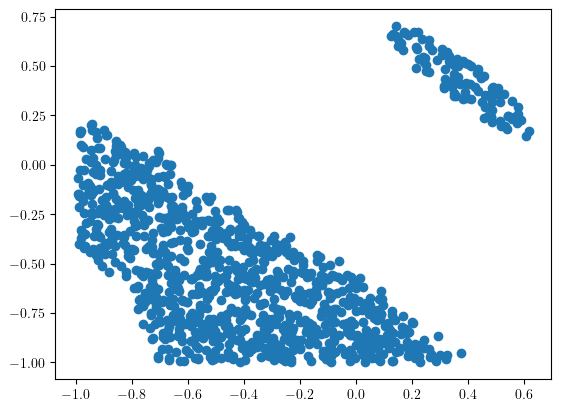

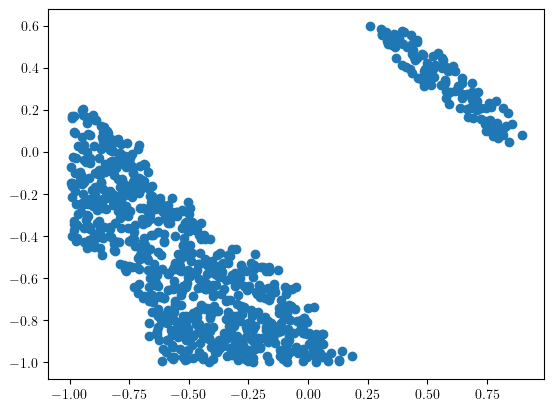

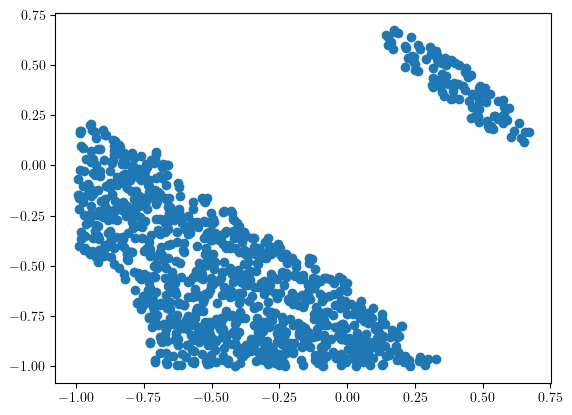

In [78]:
size_grid_for_sizes = 5_000
with open(f'{experiment_dir}/confidence_sets_for_size_waldo.pkl', 'rb') as f:
    confidence_sets_for_size_waldo = dill.load(f)
    confset_sizes_waldo = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size_waldo[0]])
with open(f'{experiment_dir}/confidence_sets_for_size.pkl', 'rb') as f:
    confidence_sets_for_size = dill.load(f)
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
with open(f'{experiment_dir}/set_for_size.pkl', 'rb') as f:
    set_for_size = dill.load(f)
    params_for_size = set_for_size['params']
    samples_for_size = set_for_size['samples']

sets_to_check = torch.norm(torch.tensor([0.4, 0.4]) - params_for_size, dim=1).sort().indices[:10]
for idx in range(len(confidence_sets_for_size_waldo[0])):
    if idx in sets_to_check:
        plt.scatter(confidence_sets_for_size_waldo[0][idx][:, 0], confidence_sets_for_size_waldo[0][idx][:, 1])
        plt.show()

/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnin

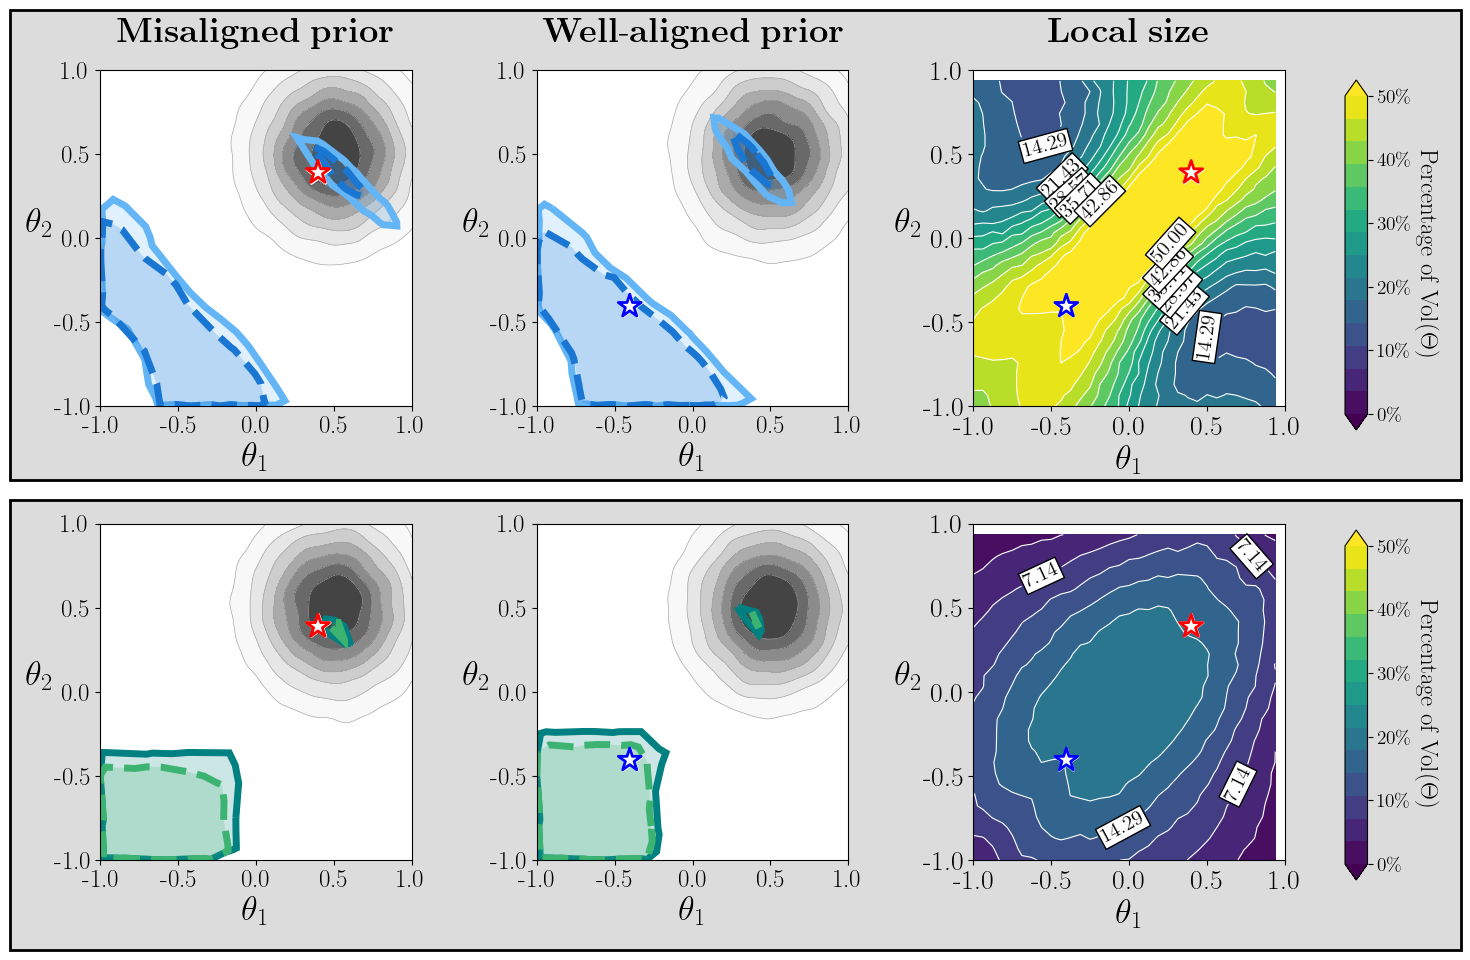

In [6]:
size_grid_for_sizes = 5_000
with open(f'{experiment_dir}/confidence_sets_for_size_waldo.pkl', 'rb') as f:
    confidence_sets_for_size_waldo = dill.load(f)
    confset_sizes_waldo = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size_waldo[0]])
with open(f'{experiment_dir}/confidence_sets_for_size.pkl', 'rb') as f:
    confidence_sets_for_size = dill.load(f)
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
with open(f'{experiment_dir}/set_for_size.pkl', 'rb') as f:
    set_for_size = dill.load(f)
    params_for_size = set_for_size['params']
    samples_for_size = set_for_size['samples']

idx_1 = torch.norm(torch.tensor([0.4, 0.4]) - params_for_size, dim=1).argmin().item()
idx_2 = torch.norm(torch.tensor([-0.4, -0.4]) - params_for_size, dim=1).argmin().item()

confidence_setsw = confidence_sets_for_size_waldo
confidence_sets = confidence_sets_for_size

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig, left=0.09, top=0.91, bottom=0.12, right=0.88, hspace=0.35, wspace=0.4)

# Create axes from gridspec
axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# Add gainsboro patches behind each row (non-overlapping)
# Top row patch
fig.patches.append(patches.Rectangle(
    (0.03, 0.5), 0.967, 0.47, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

# Bottom row patch
fig.patches.append(patches.Rectangle(
    (0.03, 0.03), 0.967, 0.45, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

idx_obs = idx_1
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=params_for_size[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Misaligned\ prior}$',
    custom_ax=axs[0][0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=params_for_size[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][0]
)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Well\text{-}aligned\ prior}$',
    custom_ax=axs[0][1]
)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][1]
)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Top row set_size_plot
size_plot_top = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes_waldo,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 50),
    title=r'$\mathbf{Local\ size}$',
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[0][2]
)

idx_obs = idx_1
true_parameter=params_for_size[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Bottom row set_size_plot
size_plot_bottom = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 50),
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[1][2]
)

idx_obs = idx_1
true_parameter=params_for_size[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Add colorbar for top row (rightmost column)
cax_top = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cbar_top = fig.colorbar(size_plot_top, cax=cax_top)
standard_ticks = np.round(np.linspace(0, 50, num=6), 1)
tick_labels = [f"{label:.0f}\%" for label in standard_ticks]
cbar_top.ax.yaxis.set_ticks(standard_ticks)
cbar_top.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_top.ax.yaxis.set_ticks_position('right')
cbar_top.ax.yaxis.set_label_position('right')
cbar_top.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

# Add colorbar for bottom row (rightmost column)
cax_bottom = fig.add_axes([0.92, 0.10, 0.015, 0.35])
cbar_bottom = fig.colorbar(size_plot_bottom, cax=cax_bottom)
cbar_bottom.ax.yaxis.set_ticks(standard_ticks)
cbar_bottom.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_bottom.ax.yaxis.set_ticks_position('right')
cbar_bottom.ax.yaxis.set_label_position('right')
cbar_bottom.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

plt.savefig(f'{experiment_dir}/freb_v_waldo.png', dpi=100)
plt.savefig(f'{experiment_dir}/freb_v_waldo.pdf', dpi=100)
plt.show()

# Uniform prior

In [17]:
experiment_dir = 'results/snpe/uniform_prior'
with open(f'{experiment_dir}/obs_x_theta.pkl', 'rb') as f:
    examples = dill.load(f)
    true_theta = examples['true_theta']
    obs_x = examples['obs_x']

PRIOR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
)

In [18]:
with open(f'{experiment_dir}/confidence_sets_for_size_waldo.pkl', 'rb') as f:
    confidence_sets_for_size_waldo = dill.load(f)
    confset_sizes_waldo = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size_waldo[0]])
with open(f'{experiment_dir}/confidence_sets_for_size.pkl', 'rb') as f:
    confidence_sets_for_size = dill.load(f)
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
with open(f'{experiment_dir}/set_for_size.pkl', 'rb') as f:
    set_for_size = dill.load(f)
    params_for_size = set_for_size['params']
    samples_for_size = set_for_size['samples']

/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnin

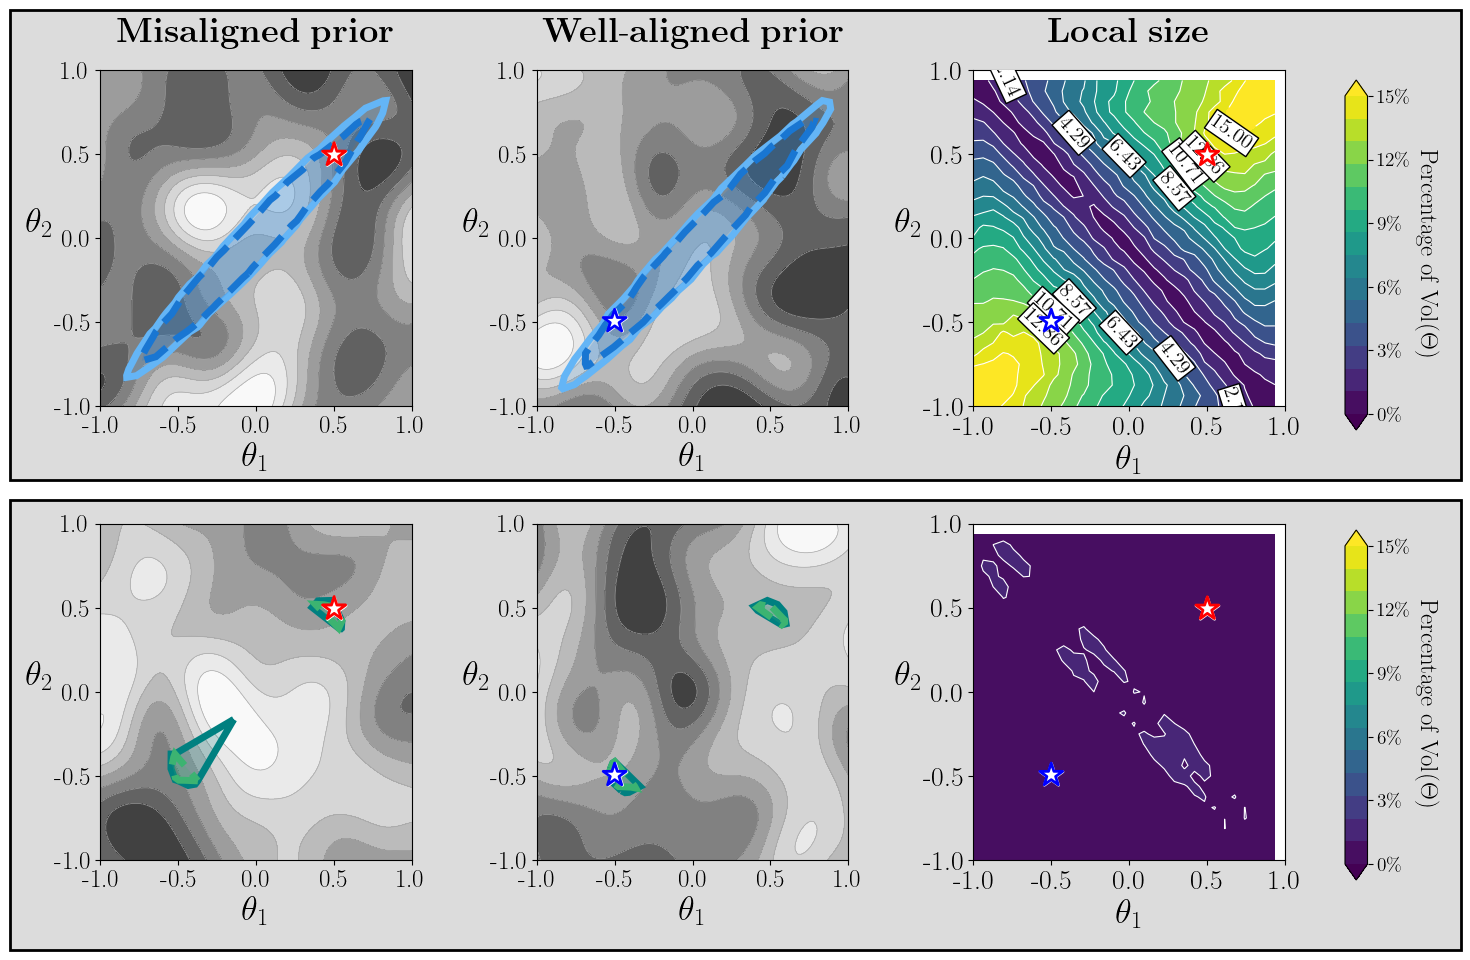

In [45]:
size_grid_for_sizes = 5_000
with open(f'{experiment_dir}/confidence_sets_for_size_waldo.pkl', 'rb') as f:
    confidence_sets_for_size_waldo = dill.load(f)
    confset_sizes_waldo = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size_waldo[0]])
with open(f'{experiment_dir}/confidence_sets_for_size.pkl', 'rb') as f:
    confidence_sets_for_size = dill.load(f)
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
with open(f'{experiment_dir}/set_for_size.pkl', 'rb') as f:
    set_for_size = dill.load(f)
    params_for_size = set_for_size['params']
    samples_for_size = set_for_size['samples']

idx_1 = torch.norm(torch.tensor([0.5, 0.5]) - params_for_size, dim=1).argmin().item()
idx_2 = torch.norm(torch.tensor([-0.5, -0.5]) - params_for_size, dim=1).argmin().item()

confidence_setsw = confidence_sets_for_size_waldo
confidence_sets = confidence_sets_for_size

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig, left=0.09, top=0.91, bottom=0.12, right=0.88, hspace=0.35, wspace=0.4)

# Create axes from gridspec
axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# Add gainsboro patches behind each row (non-overlapping)
# Top row patch
fig.patches.append(patches.Rectangle(
    (0.03, 0.5), 0.967, 0.47, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

# Bottom row patch
fig.patches.append(patches.Rectangle(
    (0.03, 0.03), 0.967, 0.45, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

idx_obs = idx_1
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=params_for_size[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Misaligned\ prior}$',
    custom_ax=axs[0][0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=params_for_size[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][0]
)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Well\text{-}aligned\ prior}$',
    custom_ax=axs[0][1]
)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][1]
)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Top row set_size_plot
size_plot_top = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes_waldo,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 15),
    title=r'$\mathbf{Local\ size}$',
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[0][2]
)

idx_obs = idx_1
true_parameter=params_for_size[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Bottom row set_size_plot
size_plot_bottom = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 15),
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[1][2]
)

idx_obs = idx_1
true_parameter=params_for_size[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Add colorbar for top row (rightmost column)
cax_top = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cbar_top = fig.colorbar(size_plot_top, cax=cax_top)
standard_ticks = np.round(np.linspace(0, 15, num=6), 1)
tick_labels = [f"{label:.0f}\%" for label in standard_ticks]
cbar_top.ax.yaxis.set_ticks(standard_ticks)
cbar_top.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_top.ax.yaxis.set_ticks_position('right')
cbar_top.ax.yaxis.set_label_position('right')
cbar_top.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

# Add colorbar for bottom row (rightmost column)
cax_bottom = fig.add_axes([0.92, 0.10, 0.015, 0.35])
cbar_bottom = fig.colorbar(size_plot_bottom, cax=cax_bottom)
cbar_bottom.ax.yaxis.set_ticks(standard_ticks)
cbar_bottom.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_bottom.ax.yaxis.set_ticks_position('right')
cbar_bottom.ax.yaxis.set_label_position('right')
cbar_bottom.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

plt.savefig(f'{experiment_dir}/freb_v_waldo.png', dpi=100)
plt.savefig(f'{experiment_dir}/freb_v_waldo.pdf', dpi=100)
plt.show()

/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/export/jcarzon/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnin

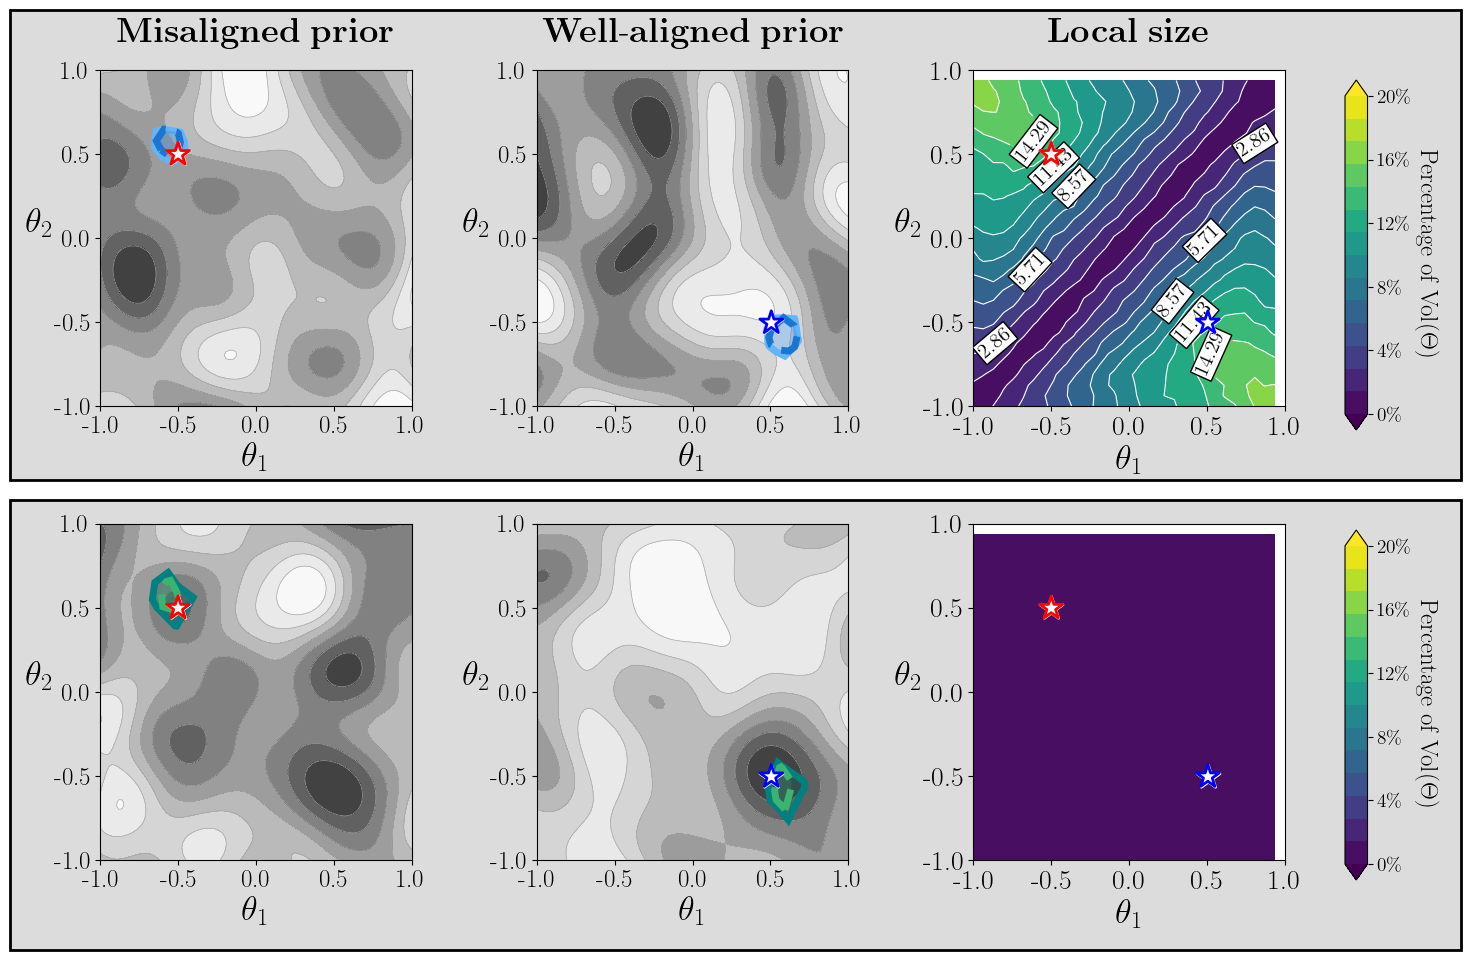

In [22]:
size_grid_for_sizes = 5_000
with open(f'{experiment_dir}/confidence_sets_for_size_waldo.pkl', 'rb') as f:
    confidence_sets_for_size_waldo = dill.load(f)
    confset_sizes_waldo = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size_waldo[0]])
with open(f'{experiment_dir}/confidence_sets_for_size.pkl', 'rb') as f:
    confidence_sets_for_size = dill.load(f)
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
with open(f'{experiment_dir}/set_for_size.pkl', 'rb') as f:
    set_for_size = dill.load(f)
    params_for_size = set_for_size['params']
    samples_for_size = set_for_size['samples']

idx_1 = torch.norm(torch.tensor([-0.5, 0.5]) - params_for_size, dim=1).argmin().item()
idx_2 = torch.norm(torch.tensor([0.5, -0.5]) - params_for_size, dim=1).argmin().item()

confidence_setsw = confidence_sets_for_size_waldo
confidence_sets = confidence_sets_for_size

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig, left=0.09, top=0.91, bottom=0.12, right=0.88, hspace=0.35, wspace=0.4)

# Create axes from gridspec
axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# Add gainsboro patches behind each row (non-overlapping)
# Top row patch
fig.patches.append(patches.Rectangle(
    (0.03, 0.5), 0.967, 0.47, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

# Bottom row patch
fig.patches.append(patches.Rectangle(
    (0.03, 0.03), 0.967, 0.45, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

idx_obs = idx_1
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=params_for_size[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Misaligned\ prior}$',
    custom_ax=axs[0][0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=params_for_size[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][0]
)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Well\text{-}aligned\ prior}$',
    custom_ax=axs[0][1]
)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][1]
)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Top row set_size_plot
size_plot_top = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes_waldo,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 20),
    title=r'$\mathbf{Local\ size}$',
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[0][2]
)

idx_obs = idx_1
true_parameter=params_for_size[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Bottom row set_size_plot
size_plot_bottom = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 20),
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[1][2]
)

idx_obs = idx_1
true_parameter=params_for_size[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
true_parameter=params_for_size[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Add colorbar for top row (rightmost column)
cax_top = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cbar_top = fig.colorbar(size_plot_top, cax=cax_top)
standard_ticks = np.round(np.linspace(0, 20, num=6), 1)
tick_labels = [f"{label:.0f}\%" for label in standard_ticks]
cbar_top.ax.yaxis.set_ticks(standard_ticks)
cbar_top.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_top.ax.yaxis.set_ticks_position('right')
cbar_top.ax.yaxis.set_label_position('right')
cbar_top.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

# Add colorbar for bottom row (rightmost column)
cax_bottom = fig.add_axes([0.92, 0.10, 0.015, 0.35])
cbar_bottom = fig.colorbar(size_plot_bottom, cax=cax_bottom)
cbar_bottom.ax.yaxis.set_ticks(standard_ticks)
cbar_bottom.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_bottom.ax.yaxis.set_ticks_position('right')
cbar_bottom.ax.yaxis.set_label_position('right')
cbar_bottom.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

plt.savefig(f'{experiment_dir}/freb_v_waldo_alt.png', dpi=100)
plt.savefig(f'{experiment_dir}/freb_v_waldo_alt.pdf', dpi=100)
plt.show()

In [38]:
torch.hstack([params_for_size[:, [1]], params_for_size[:, [0]]])

tensor([[-0.5157, -0.8317],
        [-0.8676, -0.5384],
        [ 0.0678,  0.9732],
        ...,
        [-0.6715, -0.5839],
        [ 0.0394, -0.9450],
        [-0.4575, -0.9220]])

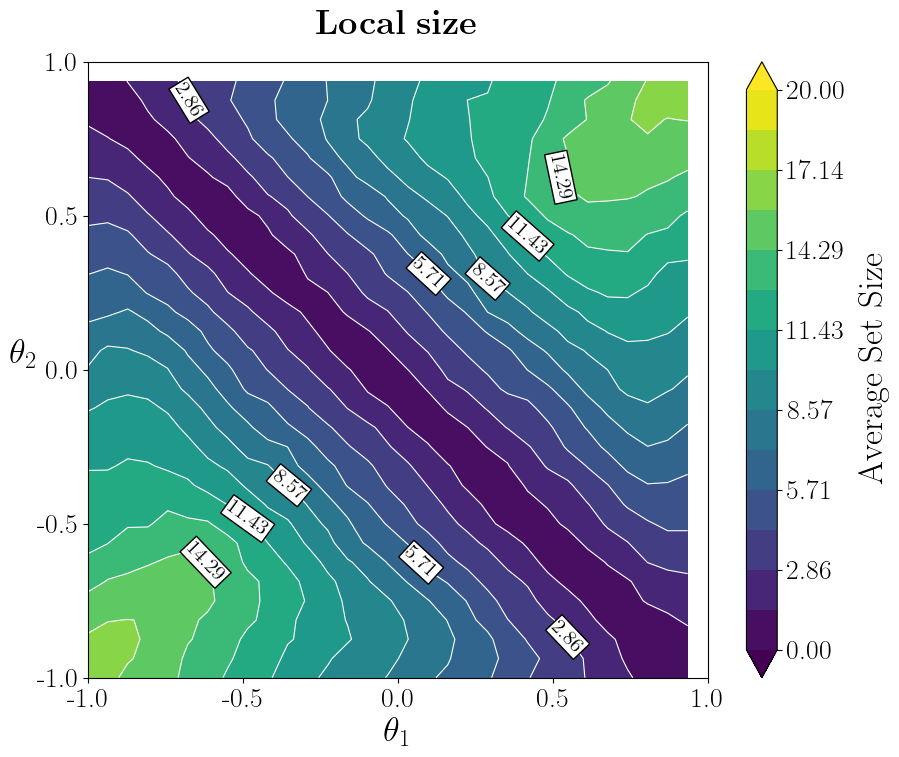

In [42]:
set_size_plot(
    parameters=params_for_size, #torch.hstack([params_for_size[:, [1]], params_for_size[:, [0]]]),
    set_sizes=confset_sizes_waldo,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 20),
    title=r'$\mathbf{Local\ size}$',
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    # custom_ax=axs[0][2]
)

# Old code

In [ ]:
### Settings
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 0.1 # (6*np.sqrt(2.0))**2
POI_BOUNDS = {r'$\theta_1$': (-1, 1), r'$\theta_2$': (-1, 1)}
PRIOR = MultivariateNormal(
    loc=torch.Tensor([0.5, 0.5]), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)

B = 100_000  # num simulations to estimate posterior and test statistics
B_PRIME = 50_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 1_000  # num simulations to do diagnostics
EVAL_GRID_SIZE = 10_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.954, 0.683  # 0.99

REFERENCE = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
)
EVAL_GRID_DISTR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][0])),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1], POI_BOUNDS[r'$\theta_2$'][1]))
)

POSTERIOR_KWARGS = {
    # 'norm_posterior': None
}
DEVICE = 'cpu'
task = sbibm.get_task('two_moons')
simulator = task.get_simulator()

In [ ]:
kdeplots2D(
    [REFERENCE.sample(sample_shape=(10_000, )), PRIOR.sample(sample_shape=(10_000, ))],
    true_theta=None,
    plot_marginals=True,
    xlim=(POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][1]), 
    ylim=(POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][1]),
    names=['universal', 'prior'],
    axis_labels=[r'$\theta_1$', r'$\theta_2$']
)

In [ ]:
with open('results/strong_prior/lf2i_strong_prior.pkl', 'rb') as f:
    lf2i = dill.load(f)
confidence_sets = lf2i.inference(
    x=obs_x,
    evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='p-values',
    calibration_model='cat-gb',
    calibration_model_kwargs={
        # 'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
        # 'n_iter': 25
        'cv': {'iterations': [100], 'depth': [3]},
        'n_iter': 1
    },
    T_prime=(b_prime_params, b_prime_samples),
    retrain_calibration=False
)

In [ ]:
with open('results/strong_prior/lf2i_strong_prior_waldo.pkl', 'rb') as f:
    lf2iw = dill.load(f)
confidence_setsw = lf2iw.inference(
    x=obs_x,
    evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='p-values',
    calibration_model='cat-gb',
    calibration_model_kwargs={
        'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
        'n_iter': 25
    },
    T_prime=(b_prime_params, b_prime_samples),
    retrain_calibration=False
)

In [ ]:
# ### NDE
# try:
#     with open('results/strong_prior/fmpe_strong_prior.pkl', 'rb') as f:
#         fmpe_posterior = dill.load(f)
# except:
#     b_params = PRIOR.sample(sample_shape=(B, ))
#     b_samples = simulator(b_params)
#     b_params.shape, b_samples.shape
#     fmpe = SNPE(
#         prior=PRIOR,
#         density_estimator='maf',
#         device='cpu'
#     )

#     _ = fmpe.append_simulations(b_params, b_samples).train()
#     fmpe_posterior = fmpe.build_posterior()
#     with open('results/strong_prior/fmpe_strong_prior.pkl', 'wb') as f:
#         dill.dump(fmpe_posterior, f)

# ### VSI
# b_prime_params = REFERENCE.sample(sample_shape=(B_PRIME, ))
# b_prime_samples = simulator(b_prime_params)
# b_prime_params.shape, b_prime_samples.shape
# try:
#     with open('results/strong_prior/obs_x_theta.pkl', 'rb') as f:
#         examples = dill.load(f)
#         true_theta = examples['true_theta']
#         obs_x = examples['obs_x']
# except:
#     true_theta = torch.Tensor([[0, 0], [0.5, -0.5], [-0.5, 0.5], [-0.5, -0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])
#     obs_x = simulator(true_theta)
#     with open('results/strong_prior/obs_x_theta.pkl', 'wb') as f:
#         dill.dump({
#             'true_theta': true_theta,
#             'obs_x': obs_x
#         }, f)

# try:
#     with open('results/strong_prior/lf2i_strong_prior.pkl', 'rb') as f:
#         lf2i = dill.load(f)
#     confidence_sets = lf2i.inference(
#         x=obs_x,
#         evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
#         confidence_level=CONFIDENCE_LEVEL,
#         calibration_method='p-values',
#         calibration_model='cat-gb',
#         calibration_model_kwargs={
#             # 'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
#             # 'n_iter': 25
#             'cv': {'iterations': [100], 'depth': [3]},
#             'n_iter': 1
#         },
#         T_prime=(b_prime_params, b_prime_samples),
#         retrain_calibration=False
#     )
# except:
#     lf2i = LF2I(test_statistic=Posterior(poi_dim=2, estimator=fmpe_posterior, **POSTERIOR_KWARGS))
#     confidence_sets = lf2i.inference(
#         x=obs_x,
#         evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
#         confidence_level=CONFIDENCE_LEVEL,
#         calibration_method='p-values',
#         calibration_model='cat-gb',
#         calibration_model_kwargs={
#             # 'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
#             # 'n_iter': 25
#             'cv': {'iterations': [100], 'depth': [3]},
#             'n_iter': 1
#         },
#         T_prime=(b_prime_params, b_prime_samples),
#         retrain_calibration=False
#     )
#     with open('results/strong_prior/lf2i_strong_prior.pkl', 'wb') as f:
#         dill.dump(lf2i, f)

# try:
#     with open('results/strong_prior/lf2i_strong_prior_waldo.pkl', 'rb') as f:
#         lf2iw = dill.load(f)
#     confidence_setsw = lf2iw.inference(
#         x=obs_x,
#         evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
#         confidence_level=CONFIDENCE_LEVEL,
#         calibration_method='p-values',
#         calibration_model='cat-gb',
#         calibration_model_kwargs={
#             'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
#             'n_iter': 25
#         },
#         T_prime=(b_prime_params, b_prime_samples),
#         retrain_calibration=False
#     )
# except:
#     lf2iw = LF2I(test_statistic=Waldo(poi_dim=2, estimator=fmpe_posterior, estimation_method='posterior', num_posterior_samples=50_000, **POSTERIOR_KWARGS))
#     confidence_setsw = lf2iw.inference(
#         x=obs_x,
#         evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
#         confidence_level=CONFIDENCE_LEVEL,
#         calibration_method='p-values',
#         calibration_model='cat-gb',
#         calibration_model_kwargs={
#             'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
#             'n_iter': 25
#         },
#         T_prime=(b_prime_params, b_prime_samples),
#         retrain_calibration=False
#     )
#     with open('results/strong_prior/lf2i_strong_prior_waldo.pkl', 'wb') as f:
#         dill.dump(lf2iw, f)

# remaining = len(obs_x)
# credible_sets = []
# for x in obs_x:  # torch.vstack([task.get_observation(i) for i in range(1, 11)])
#     print(f'Remaining: {remaining}', flush=True)
#     credible_sets_x = []
#     for cl in CONFIDENCE_LEVEL:
#         actual_cred_level, credible_set = hpd_region(
#             posterior=fmpe_posterior,
#             param_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
#             x=x.reshape(-1, ),
#             credible_level=cl,
#             num_level_sets=10_000,
#             **POSTERIOR_KWARGS
#         )
#         #print(actual_cred_level, flush=True)
#         credible_sets_x.append(credible_set)
#     credible_sets.append(credible_sets_x)
#     remaining -= 1

In [ ]:
# plt.rc('text', usetex=True)  # Enable LaTeX
# plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
# plt.rcParams['text.latex.preamble'] = r'''
#     \usepackage{amsmath}  % For \mathbb
#     \usepackage{amssymb}  % For \mathbb
#     \usepackage{bm}       % For bold math symbols
#     \usepackage{underscore} % If underscores are needed
# '''

# for idx_obs in range(8):

#     if idx_obs <= 4:
#         title = r'\textbf{a)} Prior poorly aligned with $\theta^{\star}$'
#     else:
#         title = r'\textbf{b)} Prior well aligned with $\theta^{\star}$'

#     plot_parameter_regions(
#         *credible_sets[idx_obs], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
#         param_dim=2,
#         true_parameter=true_theta[idx_obs, :],
#         prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
#         parameter_space_bounds={
#             r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
#             r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
#         },
#         # parameter_space_bounds={
#         #     r'$\theta_1$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
#         #     r'$\theta_2$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
#         # },
#         colors=[
#             'purple', 'deeppink', # 'hotpink',  # credible sets
#             #'teal', 'mediumseagreen', 'darkseagreen', # confidence sets
#         ],
#         region_names=[
#             *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
#             #*[f'CS {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
#         ],
#         labels=[r'$\theta_1$', r'$\theta_2$'],
#         linestyles=['-', '--'],  # , ':'
#         param_names=[r'$\theta_1$', r'$\theta_2$'],
#         alpha_shape=False,
#         alpha=3,
#         scatter=True,
#         figsize=(5, 5),
#         save_fig_path=f'results/strong_prior/hpd{idx_obs}.png',
#         remove_legend=True,
#         title=title,
#         custom_ax=None
#     )

# for idx_obs in range(8):

#     plot_parameter_regions(
#         *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
#         param_dim=2,
#         true_parameter=true_theta[idx_obs, :],
#         prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
#         parameter_space_bounds={
#             r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
#             r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
#         },
#         colors=[
#             #'purple', 'deeppink', 'hotpink',  # credible sets
#             'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
#         ],
#         region_names=[
#             #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
#             *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
#         ],
#         labels=[r'$\theta_1$', r'$\theta_2$'],
#         linestyles=['-', '--'],  # , ':'
#         param_names=[r'$\theta_1$', r'$\theta_2$'],
#         alpha_shape=False,
#         alpha=3,
#         scatter=True,
#         figsize=(5, 5),
#         save_fig_path=f'results/strong_prior/freb{idx_obs}.png',
#         remove_legend=True,
#         title='FreB with Posterior',
#         custom_ax=None
#     )

# for idx_obs in range(8):

#     plot_parameter_regions(
#         *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
#         param_dim=2,
#         true_parameter=true_theta[idx_obs, :],
#         prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
#         parameter_space_bounds={
#             r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
#             r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
#         },
#         colors=[
#             #'purple', 'deeppink', 'hotpink',  # credible sets
#             'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
#         ],
#         region_names=[
#             #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
#             *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
#         ],
#         labels=[r'$\theta_1$', r'$\theta_2$'],
#         linestyles=['-', '--'],  # , ':'
#         param_names=[r'$\theta_1$', r'$\theta_2$'],
#         alpha_shape=False,
#         alpha=3,
#         scatter=True,
#         figsize=(5, 5),
#         save_fig_path=f'results/strong_prior/freb_waldo{idx_obs}.png',
#         remove_legend=True,
#         title='FreB with Waldo',
#         custom_ax=None
#     )

In [ ]:
try:
    with open('results/strong_prior/diagn_confset_strong_prior.pkl', 'rb') as f:
        diagn_objects = dill.load(f)
    with open('results/strong_prior/diagn_confset_strong_prior_waldo.pkl', 'rb') as f:
        diagn_objectsw = dill.load(f)
    with open('results/strong_prior/diagn_cred_strong_prior.pkl', 'rb') as f:
        diagn_objects_cred = dill.load(f)
    with open('results/strong_prior/b_double_prime.pkl', 'rb') as f:
        b_double_prime = dill.load(f)
        b_double_prime_params, b_double_prime_samples = b_double_prime['params'], b_double_prime['samples']
except:
    b_double_prime_params = REFERENCE.sample(sample_shape=(B_DOUBLE_PRIME, ))
    b_double_prime_samples = simulator(b_double_prime_params)
    b_double_prime_params.shape, b_double_prime_samples.shape
    with open('results/strong_prior/b_double_prime.pkl', 'wb') as f:
        dill.dump({
            'params': b_double_prime_params,
            'samples': b_double_prime_samples
        }, f)

    diagn_objects = {}
    for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
        print(cl, flush=True)
        diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = lf2i.diagnostics(
            region_type='lf2i',
            confidence_level=cl,
            calibration_method='p-values',
            coverage_estimator='splines',
            T_double_prime=(b_double_prime_params, b_double_prime_samples),
        )
        diagn_objects[cl] = (diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset)
    with open('results/strong_prior/diagn_confset_strong_prior.pkl', 'wb') as f:
        dill.dump(diagn_objects, f)

    plt.scatter(out_parameters_confset[:, 0], out_parameters_confset[:, 1], c=mean_proba_confset)
    plt.title('Coverage of FreB confidence sets')
    plt.clim(vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig('results/strong_prior/freb_coverage')
    plt.close()

    diagn_objectsw = {}
    for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
        print(cl, flush=True)
        diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = lf2iw.diagnostics(
            region_type='lf2i',
            confidence_level=cl,
            calibration_method='p-values',
            coverage_estimator='splines',
            T_double_prime=(b_double_prime_params, b_double_prime_samples),
        )
        diagn_objects[cl] = (diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset)
    with open('results/strong_prior/diagn_confset_strong_prior_waldo.pkl', 'wb') as f:
        dill.dump(diagn_objectsw, f)

    plt.scatter(out_parameters_confset[:, 0], out_parameters_confset[:, 1], c=mean_proba_confset)
    plt.title('Coverage of Waldo confidence sets')
    plt.clim(vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig('results/strong_prior/waldo_coverage')
    plt.close()

    diagn_objects_cred = {}
    size_grid_for_sizes = 5_000
    for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
        print(cl, flush=True)
        diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes = lf2i.diagnostics(
            region_type='posterior',
            confidence_level=cl,
            coverage_estimator='splines',
            T_double_prime=(b_double_prime_params, b_double_prime_samples),
            posterior_estimator=lf2i.test_statistic.estimator,
            evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
            num_level_sets=5_000,
            **POSTERIOR_KWARGS
        )
        diagn_objects_cred[cl] = (diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes)
    with open('results/strong_prior/diagn_cred_strong_prior.pkl', 'wb') as f:
        dill.dump(diagn_objects_cred, f)

    plt.scatter(out_parameters_credible[:, 0], out_parameters_credible[:, 1], c=mean_proba_credible)
    plt.title('Coverage of credible regions')
    plt.clim(vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig('results/strong_prior/hpd_coverage')
    plt.close()

In [ ]:
try:
    with open('results/strong_prior/confidence_sets_for_size.pkl', 'rb') as f:
        confidence_sets_for_size = dill.load(f)
    with open('results/strong_prior/set_for_size.pkl', 'rb') as f:
        set_for_size = dill.load(f)
        params_for_size = set_for_size['params']
        samples_for_size = set_for_size['samples']
except:
    params_for_size = EVAL_GRID_DISTR.sample(sample_shape=(B_DOUBLE_PRIME, ))
    samples_for_size = simulator(params_for_size)
    params_for_size.shape, samples_for_size.shape
    with open('results/strong_prior/set_for_size.pkl', 'wb') as f:
        dill.dump({
            'params': params_for_size,
            'samples': samples_for_size
        }, f)

    size_grid_for_sizes = 5_000
    confidence_sets_for_size = lf2i.inference(
        x=samples_for_size,
        evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
        confidence_level=CONFIDENCE_LEVEL,
        calibration_method='p-values',
    )
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
    with open('results/strong_prior/confidence_sets_for_size.pkl', 'wb') as f:
        dill.dump(confidence_sets_for_size, f)

    plt.scatter(params_for_size[:, 0], params_for_size[:, 1], c=confset_sizes)
    plt.clim(0, 100)
    plt.colorbar()
    plt.title('FreB sizes, 1-100\%')
    plt.savefig('results/strong_prior/freb_sizes_fixed_scale.png')
    plt.close()

    plt.scatter(params_for_size[:, 0], params_for_size[:, 1], c=confset_sizes)
    plt.colorbar()
    plt.title('FreB sizes')
    plt.savefig('results/strong_prior/freb_sizes.png')
    plt.close()

In [ ]:
try:
    with open('results/strong_prior/confidence_sets_for_size_waldo.pkl', 'rb') as f:
        confidence_sets_for_size = dill.load(f)
except:
    size_grid_for_sizes = 5_000
    confidence_sets_for_size = lf2iw.inference(
        x=samples_for_size,
        evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
        confidence_level=CONFIDENCE_LEVEL,
        calibration_method='p-values',
    )
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])
    with open('results/strong_prior/confidence_sets_for_size_waldo.pkl', 'wb') as f:
        dill.dump(confidence_sets_for_size, f)

    plt.scatter(params_for_size[:, 0], params_for_size[:, 1], c=confset_sizes)
    plt.clim(0, 100)
    plt.colorbar()
    plt.title('Waldo sizes, 1-100\%')
    plt.savefig('results/strong_prior/waldo_sizes_fixed_scale.png')
    plt.close()

    plt.scatter(params_for_size[:, 0], params_for_size[:, 1], c=confset_sizes)
    plt.colorbar()
    plt.title('Waldo sizes')
    plt.savefig('results/strong_prior/waldo_sizes.png')
    plt.close()

In [ ]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, axs = plt.subplots(2, 3, figsize=(12, 10))

idx_obs = 3
plot_parameter_regions(
    *credible_sets[idx_obs], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    # parameter_space_bounds={
    #     r'$\theta_1$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
    #     r'$\theta_2$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
    # },
    colors=[
        'purple', 'deeppink', # 'hotpink',  # credible sets
        #'teal', 'mediumseagreen', 'darkseagreen', # confidence sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
        #*[f'CS {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],  # , ':'
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # figsize=(5, 5),
    # save_fig_path=f'results/strong_prior/hpd{idx_obs}.png',
    remove_legend=True,
    title='Misaligned prior',
    custom_ax=axs[0, 0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        #'purple', 'deeppink', 'hotpink',  # credible sets
        'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
    ],
    region_names=[
        #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],  # , ':'
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # figsize=(5, 5),
    # save_fig_path=f'results/strong_prior/freb{idx_obs}.png',
    remove_legend=True,
    title=None,
    custom_ax=axs[1, 0]
)

idx_obs = 4
plot_parameter_regions(
    *credible_sets[idx_obs], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    # parameter_space_bounds={
    #     r'$\theta_1$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
    #     r'$\theta_2$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
    # },
    colors=[
        'purple', 'deeppink', # 'hotpink',  # credible sets
        #'teal', 'mediumseagreen', 'darkseagreen', # confidence sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
        #*[f'CS {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],  # , ':'
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # figsize=(5, 5),
    # save_fig_path=f'results/strong_prior/hpd{idx_obs}.png',
    remove_legend=True,
    title='Well-aligned prior',
    custom_ax=axs[0, 1]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        #'purple', 'deeppink', 'hotpink',  # credible sets
        'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
    ],
    region_names=[
        #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],  # , ':'
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # figsize=(5, 5),
    # save_fig_path=f'results/strong_prior/freb{idx_obs}.png',
    remove_legend=True,
    title=None,
    custom_ax=axs[1, 1]
)

with open('results/strong_prior/diagn_confset_strong_prior.pkl', 'rb') as f:
    diagn_objects = dill.load(f)
with open('results/strong_prior/diagn_cred_strong_prior.pkl', 'rb') as f:
    diagn_objects_cred = dill.load(f)

diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes = diagn_objects_cred[CONFIDENCE_LEVEL[0]]
diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = diagn_objects[CONFIDENCE_LEVEL[0]]

# coverage_probability_plot(
#     parameters=out_parameters_credible,
#     coverage_probability=mean_proba_credible,
#     confidence_level=CONFIDENCE_LEVEL[0],
#     param_dim=2,
#     params_labels=[r'$\theta_1$', r'$\theta_2$'],
#     vmin_vmax=(0, 1),
#     custom_ax=axs[0,2],  # if passing custom ax for pairplot
#     title=None
# )
# Correct syntax
scatter = axs[0, 2].scatter(
    out_parameters_credible[:, 0], 
    out_parameters_credible[:, 1], 
    c=mean_proba_credible
)
axs[0, 2].set_title('Local diagnostics', size=25, pad=20)

# Set color limits on the ScalarMappable (scatter object), not the axis
scatter.set_clim(vmin=0, vmax=1)

# Add colorbar - needs fig and the scatter object
plt.colorbar(scatter, ax=axs[0, 2])

# coverage_probability_plot(
#     parameters=out_parameters_confset,
#     coverage_probability=mean_proba_confset,
#     confidence_level=CONFIDENCE_LEVEL[0],
#     param_dim=2,
#     params_labels=[r'$\theta_1$', r'$\theta_2$'],
#     vmin_vmax=(0, 1),
#     custom_ax=axs[1,2],  # if passing custom ax for pairplot
#     title=None
# )
scatter = axs[1, 2].scatter(
    out_parameters_confset[:, 0],
    out_parameters_confset[:, 1],
    c=mean_proba_confset
)
# axs[1, 2].set_title('Coverage of FreB sets')

scatter.set_clim(vmin=0, vmax=1)
plt.colorbar(scatter, ax=axs[1, 2])

plt.show()

In [ ]:
size_grid_for_sizes = 5_000
with open('results/strong_prior/confidence_sets_for_size_waldo.pkl', 'rb') as f:
    confidence_sets_for_size_waldo = dill.load(f)
    confset_sizes_waldo = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size_waldo[0]])
with open('results/strong_prior/confidence_sets_for_size.pkl', 'rb') as f:
    confidence_sets_for_size = dill.load(f)
    confset_sizes = np.array([100*cs.shape[0]/size_grid_for_sizes for cs in confidence_sets_for_size[0]])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig, left=0.09, top=0.91, bottom=0.12, right=0.88, hspace=0.35, wspace=0.4)

# Create axes from gridspec
axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# Add gainsboro patches behind each row (non-overlapping)
# Top row patch
fig.patches.append(patches.Rectangle(
    (0.03, 0.5), 0.967, 0.47, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

# Bottom row patch
fig.patches.append(patches.Rectangle(
    (0.03, 0.03), 0.967, 0.45, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

idx_obs = 3
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Misaligned\ prior}$',
    custom_ax=axs[0][0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][0]
)

idx_obs = 4
true_parameter=true_theta[idx_obs, :]
plot_parameter_regions(
    *[confidence_setsw[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        '#64B5F6', '#1976D2'
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Well\text{-}aligned\ prior}$',
    custom_ax=axs[0][1]
)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][1]
)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Top row set_size_plot
size_plot_top = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes_waldo,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 50),
    title=r'$\mathbf{Local\ size}$',
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[0][2]
)

idx_obs = 3
true_parameter=true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = 4
true_parameter=true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Bottom row set_size_plot
size_plot_bottom = set_size_plot(
    parameters=params_for_size,
    set_sizes=confset_sizes,
    param_dim=2,
    xlims=POI_BOUNDS[r'$\theta_1$'],
    ylims=POI_BOUNDS[r'$\theta_2$'],
    vmin_vmax=(0, 50),
    params_labels=[r'$\theta_1$', r'$\theta_2$'],
    custom_ax=axs[1][2]
)

idx_obs = 3
true_parameter=true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = 4
true_parameter=true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

# Add colorbar for top row (rightmost column)
cax_top = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cbar_top = fig.colorbar(size_plot_top, cax=cax_top)
standard_ticks = np.round(np.linspace(0, 50, num=6), 1)
tick_labels = [f"{label:.0f}\%" for label in standard_ticks]
cbar_top.ax.yaxis.set_ticks(standard_ticks)
cbar_top.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_top.ax.yaxis.set_ticks_position('right')
cbar_top.ax.yaxis.set_label_position('right')
cbar_top.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

# Add colorbar for bottom row (rightmost column)
cax_bottom = fig.add_axes([0.92, 0.10, 0.015, 0.35])
cbar_bottom = fig.colorbar(size_plot_bottom, cax=cax_bottom)
cbar_bottom.ax.yaxis.set_ticks(standard_ticks)
cbar_bottom.ax.set_yticklabels(tick_labels, fontsize=14)
cbar_bottom.ax.yaxis.set_ticks_position('right')
cbar_bottom.ax.yaxis.set_label_position('right')
cbar_bottom.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

plt.savefig('results/strong_prior/freb_v_waldo.png', dpi=100)
plt.savefig('results/strong_prior/freb_v_waldo.pdf', dpi=100)
plt.show()